# Multi-class classification of promotion description in grocery stores

- we use here classification methods in order to classify promotion descriptions in grocery stores into promotion categories. The aim is to classify future promotions with the defined categories
- we are testing the methods with a single run and with cross validation for hyperparameter tuning

In [1]:
import math 
import random
import pandas as pd
import numpy as np
from collections import Counter

from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

#### Loading the data

In [2]:
category_description = pd.read_excel('promotion_id.xlsx')
category_description['PromotionID_Ordered'] = np.arange(1,len(category_description)+1,1)-1
category_description.head()

,PromotionID,PromotionType,PromotionID_Ordered
0,10.0,מחיר מוזל,0
1,20.0,"Y גרם/קילו ב-X ש""ח",1
2,22.0,"2 יחידות ב-X ש""ח",2
3,23.0,"3 יחידות ב-X ש""ח",3
4,24.0,"4 יחידות ב-X ש""ח",4


In [3]:
#import the data for each category
categories = ['pasta','yogurt','cheese','toothpaste','black_coffee','toilet_paper']

data = pd.read_excel('promotion_id.xlsx', sheet_name='rice')
for cat in categories:
    data = pd.concat([data,pd.read_excel('promotion_id.xlsx', sheet_name=cat)])

data

,PromotionDescription,PromotionID
0,מחיר מוזל. הרשת רשאית לשנות מבצעים בכל עת.,10.0
1,2 קילו ב-22 ₪. הרשת רשאית לשנות מבצעים בכל עת.,22.0
2,2 קילו ב-12 ₪. הרשת רשאית לשנות מבצעים בכל עת.,22.0
3,2 קילו ב-25 ₪. הרשת רשאית לשנות מבצעים בכל עת.,22.0
4,2 קילו ב-20 ₪. הרשת רשאית לשנות מבצעים בכל עת.,22.0
...,...,...
207,"מחיר מוזל. מותנה ברכישה של 75.00 ש""ח ומעלה ממו...",30.0
208,"מחיר מוזל. מותנה ברכישה של 75.00 ש""ח ומעלה ממו...",30.0
209,"מחיר מוזל. מותנה ברכישה של 75.00 ש""ח ומעלה ממו...",30.0
210,"מחיר מוזל. מותנה ברכישה של 75.00 ש""ח ומעלה ממו...",30.0


#### Cleaning data

In [4]:
data = data.drop_duplicates().reset_index(drop=True)
data = pd.merge(data, category_description, on="PromotionID")
data

,PromotionDescription,PromotionID,PromotionType,PromotionID_Ordered
0,מחיר מוזל. הרשת רשאית לשנות מבצעים בכל עת.,10.0,מחיר מוזל,0
1,"מחיר מוזל. מוגבל ל-3 מימושים / ק""ג בקניה אחת. ...",10.0,מחיר מוזל,0
2,"מחיר מוזל. מוגבל ל-1 מימושים / ק""ג בקניה אחת. ...",10.0,מחיר מוזל,0
3,"מחיר מוזל. מוגבל ל-2 מימושים / ק""ג בקניה אחת. ...",10.0,מחיר מוזל,0
4,"מחיר מוזל. מוגבל ל-4 מימושים / ק""ג בקניה אחת. ...",10.0,מחיר מוזל,0
...,...,...,...,...
1540,3 יחידות ב-20 ₪. הרשת רשאית לשנות מבצעים בכל עת.,23.0,"3 יחידות ב-X ש""ח",3
1541,3 יחידות ב-9.4 ₪. הרשת רשאית לשנות מבצעים בכל עת.,23.0,"3 יחידות ב-X ש""ח",3
1542,2 יחידות ב-25.6 ₪. הרשת רשאית לשנות מבצעים בכל...,23.0,"3 יחידות ב-X ש""ח",3
1543,6 יחידות ב-25 ₪. הרשת רשאית לשנות מבצעים בכל עת.,26.0,"6 יחידות ב-X ש""ח",6


In [5]:
data['PromotionDescription'] = data['PromotionDescription'].astype('str')

### EDA

##### taking a look at some promotion descriptions

In [6]:
data['PromotionDescription'][0:5]

0           מחיר מוזל. הרשת רשאית לשנות מבצעים בכל עת.
1    מחיר מוזל. מוגבל ל-3 מימושים / ק"ג בקניה אחת. ...
2    מחיר מוזל. מוגבל ל-1 מימושים / ק"ג בקניה אחת. ...
3    מחיר מוזל. מוגבל ל-2 מימושים / ק"ג בקניה אחת. ...
4    מחיר מוזל. מוגבל ל-4 מימושים / ק"ג בקניה אחת. ...
Name: PromotionDescription, dtype: object

##### create Bag-Of-Word matrix

In [7]:
vectorizer_eda = CountVectorizer()
bow_ex = vectorizer_eda.fit_transform(data['PromotionDescription'])
pd.DataFrame(bow_ex.toarray(),columns=vectorizer_eda.get_feature_names())

,00,01,02,03,04,05,06,07,08,09,...,פלוס,פריט,קופון,קילו,קנה,רשאית,שבמבצע,של,שלם,תיתכנה
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1541,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1542,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


##### Plot the length distribution for the Promotion Description

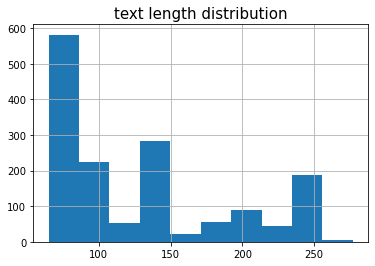

In [8]:
def plot_word_number_histogram(text):
    text.str.split().\
    map(lambda x: len(str(x))).\
    hist()
    plt.title('text length distribution',fontsize=15)
        
plot_word_number_histogram(data['PromotionDescription'])

##### Plot the category frequency 

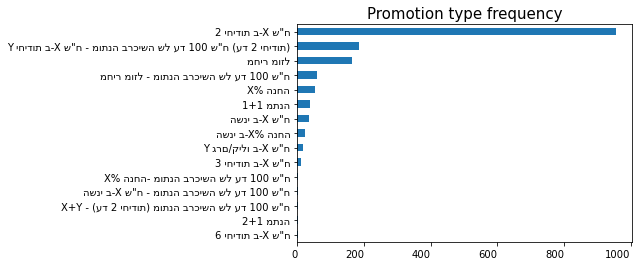

In [9]:
data['PromotionType'].value_counts()[:15].plot.barh().invert_yaxis()
plt.xticks(ha='right')
plt.title('Promotion type frequency',fontsize=15)
plt.show()

### Training

Data preparation

In [10]:
#For running the models with cross validation

X, y = data['PromotionDescription'],data['PromotionID_Ordered']

# transform the sentences into tokens
vectorizer_x = CountVectorizer()
x_vec = vectorizer_x.fit_transform(X)

In [11]:
# dulpicate entries with one instance to allow to stratify the train-test datasets
all_keys = data['PromotionID_Ordered'].unique().tolist()

t_df = pd.DataFrame()
c_df = pd.DataFrame()

for key in all_keys:
    if data.loc[data['PromotionID_Ordered']==key].shape[0] < 2 :
        t_df = t_df.append(data.loc[data['PromotionID_Ordered']==key])
        t_df = t_df.append(data.loc[data['PromotionID_Ordered']==key])
    else:
        c_df = c_df.append(data.loc[data['PromotionID_Ordered']==key])
        
data = pd.concat([c_df,t_df]).reset_index()

In [12]:
#For running the models one time 

# assign test data size 25%
X_train, X_test, y_train, y_test = train_test_split(data['PromotionDescription'],data['PromotionID_Ordered'],stratify=data['PromotionID_Ordered'],test_size= 0.25, random_state=1)

# transform the sentences into tokens
vectorizer_train = CountVectorizer()
x_vec_train = vectorizer_train.fit_transform(X_train)
print(vectorizer_train.get_feature_names())

vectorizer_test = CountVectorizer(vocabulary= vectorizer_train.vocabulary_)
x_vec_test = vectorizer_test.transform(X_test)

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '200', '2018', '2019', '2020', '21', '22', '23', '24', '25', '250', '26', '27', '28', '29', '30', '300', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '400', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '54', '55', '56', '58', '59', '60', '62', '63', '64', '65', '66', '68', '69', '70', '72', '74', '75', '76', '77', '78', '80', '82', '83', '84', '85', '90', '91', '93', '99', 'אחד', 'אחת', 'את', 'בכל', 'בלבד', 'במחיר', 'במקרה', 'בקניה', 'ברכישה', 'גרם', 'הגבלות', 'הזול', 'המוצרים', 'הנחה', 'הסניף', 'הרכישה', 'הרשת', 'והשני', 'ומעלה', 'יחידות', 'כולל', 'כמות', 'לא', 'לחברי', 'לשנות', 'מבניהם', 'מבצעים', 'מגבילה', 'מוגבל', 'מוזל', 'מועדון', 'מותנה', 'מחיר', 'מימושים', 'מכל', 'מלא', 'ממוצרי', 'מתנה', 'נוספות', 'עד', 'על', 'עת', 'פלוס', 'פריט', 'קופון', 'קילו', 'קנה', 'רשאית', 'שבמבצע', 'של', 'שלם', 'תיתכנה']


In [13]:
# Since our data is unbalanced we will oversample the minority classes in the training data
over_dict = dict(Counter(y_train))

#### over sampling just for the training data
for key in over_dict:
    # increase the minority classes by 80%
    if over_dict[key] < max(y_train.value_counts()):
        over_dict[key] = min(over_dict[key]*1.8, max(y_train.value_counts()))
    # if still lower than 50% from the maximum, increase the number to 50%
    if over_dict[key] < round(max(y_train.value_counts())*0.6):
        over_dict[key] = round(max(y_train.value_counts())*0.6)

# instantiating over sampler
over = RandomOverSampler(sampling_strategy=over_dict)

# perform oversampling to minority class
X_over, y_over = over.fit_resample(x_vec_train, y_train)

x_vec_train, y_train = X_over, y_over


#### over sampling for all the data
over_dict = dict(Counter(y))
for key in over_dict:
    # increase the minority classes by 80%
    if over_dict[key] < max(y.value_counts()):
        over_dict[key] = min(over_dict[key]*1.8, max(y.value_counts()))
    # if still lower than 50% from the maximum, increase the number to 50%
    if over_dict[key] < round(max(y.value_counts())*0.6):
        over_dict[key] = round(max(y.value_counts())*0.6)

# instantiating over sampler
over = RandomOverSampler(sampling_strategy=over_dict)

# perform oversampling to minority class
X_over, y_over = over.fit_resample(x_vec, y)

x_vec, y = X_over, y_over

In [14]:
# track model performance
log_models = pd.DataFrame(columns=["Classifier", "Accuracy","Balanced Accuracy"])

## Naive Bayes classifier

In [15]:
# Predict labels ruuning the model one time 

# call the model
mnb = MultinomialNB()

# train the model for one time
mnb.fit(x_vec_train, y_train)

# prediction accuracy of the train data
y_pred_train = mnb.predict(x_vec_train)
print('Accuracy of train data: ',accuracy_score(y_pred_train, y_train))

# prediction accuracy of the test data
y_pred_test = mnb.predict(x_vec_test)
print('Accuracy of test data: ',accuracy_score(y_test, y_pred_test))

Accuracy of train data:  0.9306543881679922
Accuracy of test data:  0.7551546391752577


<AxesSubplot:>

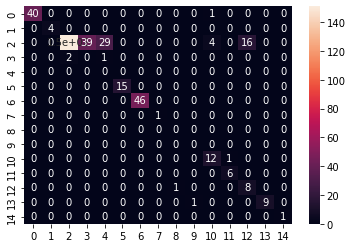

In [16]:
## confusion matrix
# passing actual and predicted values
cm = confusion_matrix(y_test, y_pred_test)

# true write data values in each cell of the matrix
sns.heatmap(cm, annot=True)

In [17]:
# printing the report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        41
           1       1.00      1.00      1.00         4
           2       0.99      0.63      0.77       239
           3       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         0
          10       1.00      1.00      1.00        15
          11       1.00      1.00      1.00        46
          13       1.00      1.00      1.00         1
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.71      0.92      0.80        13
          18       0.86      1.00      0.92         6
          19       0.33      0.89      0.48         9
          20       1.00      0.90      0.95        10
          21       1.00      1.00      1.00         1

    accuracy                           0.76       388
   macro avg       0.66      0.69      0.66       388
weighted avg       0.96   

##### Using cross validation

In [18]:
# Predict labels ruuning the model using cross validation

# call the model
mnb = MultinomialNB()

cv_scores = cross_val_score(mnb, x_vec, y, cv=5)
print('Mean accuracy: ', round(cv_scores.mean()*100, 3), '% std: ', round(math.sqrt(cv_scores.var())*100, 3),'%')
print('The accuracy for cross validation is: ', round(cv_scores.mean(), 3), ' compared to single time training: ', round(accuracy_score(y_test, y_pred_test), 3))

Mean accuracy:  91.313 % std:  1.778 %
The accuracy for cross validation is:  0.913  compared to single time training:  0.755


Using grid search cv method to optimize alpha parameter

In [19]:
# define the parameter space
param_grid = {"alpha": [0, 1]}

# perform grid search
mnb = MultinomialNB()
grid_search = GridSearchCV(mnb, param_grid, verbose=2)
grid_search.fit(x_vec_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ............................................alpha=0; total time=   0.0s
[CV] END ............................................alpha=0; total time=   0.0s
[CV] END ............................................alpha=0; total time=   0.0s
[CV] END ............................................alpha=0; total time=   0.0s
[CV] END ............................................alpha=0; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s


GridSearchCV(estimator=MultinomialNB(), param_grid={'alpha': [0, 1]}, verbose=2)

In [20]:
# plot in table the result of grid search
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004150,0.00021,0.000890,0.000095,0,{'alpha': 0},0.956764,0.960948,0.955338,0.956734,0.957432,0.957443,0.001880,1
1,0.004909,0.00054,0.001033,0.000200,1,{'alpha': 1},0.930265,0.931660,0.921144,0.923238,0.925331,0.926328,0.004033,2


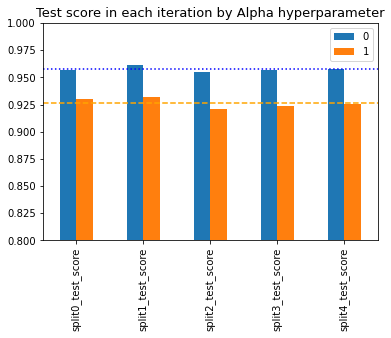

In [21]:
grid_search_results[['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score']].T.plot(kind="bar")
plt.axhline(grid_search_results['mean_test_score'][0], color='blue', ls='dotted')
plt.axhline(grid_search_results['mean_test_score'][1], color='orange', ls='dashed')
plt.title('Test score in each iteration by Alpha hyperparameter',fontsize=13)
plt.ylim((0.80,1))
plt.show()

In [22]:
# prediction accuracy of the train data
y_pred_train = grid_search.predict(x_vec_train)
print('Accuracy of best estimator of alpha with the train data: ',accuracy_score(y_pred_train, y_train))

# prediction accuracy of the test data
y_pred_test = grid_search.predict(x_vec_test)
print('Accuracy of best estimator of alpha with the test data: ',accuracy_score(y_test, y_pred_test))
print('The chosen hyperparameter is: ', grid_search.best_params_)

Accuracy of best estimator of alpha with the train data:  0.95925770894377
Accuracy of best estimator of alpha with the test data:  0.8814432989690721
The chosen hyperparameter is:  {'alpha': 0}


We see that the best estimator of alpha is without smoothing

In [23]:
log_models.loc[len(log_models)] = ['Naive Bayes',accuracy_score(y_test, y_pred_test),balanced_accuracy_score(y_test, y_pred_test)]

## Logistic regression

In [24]:
# Predict labels ruuning the model one time 

# call the model
logr = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# train the model for one time
logr.fit(x_vec_train, y_train)

# prediction accuracy of the train data
y_pred_train_logr = logr.predict(x_vec_train)
print('Accuracy of train data: ',accuracy_score(y_train, y_pred_train_logr))

# prediction accuracy of the test data
y_pred_test_logr = logr.predict(x_vec_test)
print('Accuracy of test data: ',accuracy_score(y_test, y_pred_test_logr))

Accuracy of train data:  0.9836751778987024
Accuracy of test data:  0.9587628865979382


#### Using cross validation

In [25]:
# Predict labels ruuning the model using cross validation

# call the model
logr = LogisticRegression(multi_class='multinomial', solver='lbfgs')

cv_scores = cross_val_score(logr, x_vec, y, cv=5)
print('Mean accuracy: ', round(cv_scores.mean()*100, 3), '% std: ', round(math.sqrt(cv_scores.var())*100, 3),'%')
print('The accuracy for cross validation is: ', round(cv_scores.mean(), 3), ' compared to single time training: ', round(accuracy_score(y_test, y_pred_test_logr), 3))

Mean accuracy:  96.78 % std:  1.206 %
The accuracy for cross validation is:  0.968  compared to single time training:  0.959


Using grid search method to optimize alpha parameter

In [26]:
# Create the random grid
param_grid = {"C":np.logspace(-3,3,7), 
              "penalty":["l1","l2","elasticnet", "none"]}

logr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
grid_search = GridSearchCV(estimator = logr, param_grid = param_grid, cv = 3, verbose = 0)
grid_search.fit(x_vec_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(multi_class='multinomial'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']})

In [27]:
# plot in table the result of random search
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001285,0.000293,0.000000,0.000000,0.001,l1,"{'C': 0.001, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,28
1,0.108935,0.046652,0.000982,0.000194,0.001,l2,"{'C': 0.001, 'penalty': 'l2'}",0.773964,0.793219,0.797823,0.788335,0.010335,14
2,0.000926,0.000059,0.000000,0.000000,0.001,elasticnet,"{'C': 0.001, 'penalty': 'elasticnet'}",NaN,NaN,NaN,NaN,NaN,25
3,0.321098,0.020477,0.000857,0.000057,0.001,none,"{'C': 0.001, 'penalty': 'none'}",0.987861,0.984094,0.987861,0.986605,0.001776,1
4,0.000868,0.000091,0.000000,0.000000,0.01,l1,"{'C': 0.01, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,23
5,0.192193,0.011131,0.000907,0.000080,0.01,l2,"{'C': 0.01, 'penalty': 'l2'}",0.964839,0.955630,0.964420,0.961630,0.004246,13
6,0.000805,0.000065,0.000000,0.000000,0.01,elasticnet,"{'C': 0.01, 'penalty': 'elasticnet'}",NaN,NaN,NaN,NaN,NaN,19
7,0.300800,0.027405,0.000845,0.000036,0.01,none,"{'C': 0.01, 'penalty': 'none'}",0.987861,0.984094,0.987861,0.986605,0.001776,1
8,0.000862,0.000051,0.000000,0.000000,0.1,l1,"{'C': 0.1, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,17
9,0.295862,0.028529,0.000958,0.000175,0.1,l2,"{'C': 0.1, 'penalty': 'l2'}",0.982419,0.976978,0.977815,0.979071,0.002392,12


In [28]:
# prediction accuracy of the train data
y_pred_train = grid_search.predict(x_vec_train)
print('Accuracy of best estimators with the train data: ',accuracy_score(y_train,y_pred_train))

# prediction accuracy of the test data
y_pred_test = grid_search.predict(x_vec_test)
print('Accuracy of best estimator with the test data: ',accuracy_score(y_test, y_pred_test))
best_grid = grid_search.best_params_
print('The chosen hyperparameters are: ', best_grid)

Accuracy of best estimators with the train data:  0.9891167852658016
Accuracy of best estimator with the test data:  0.9072164948453608
The chosen hyperparameters are:  {'C': 0.001, 'penalty': 'none'}


In [29]:
log_models.loc[len(log_models)] = ['Logistic Regression',accuracy_score(y_test, y_pred_test),balanced_accuracy_score(y_test, y_pred_test)]

## Random forest

In [30]:
# Predict labels ruuning the model one time 

# call the model
rfc = RandomForestClassifier(bootstrap=True,
                              max_depth=12,
                              max_features='sqrt',
                              random_state=1)

# train the model for one time
rfc.fit(x_vec_train, y_train)

# prediction accuracy of the train data
y_pred_train_rf = rfc.predict(x_vec_train)
print('Accuracy of train data: ',accuracy_score(y_train, y_pred_train_rf))

# prediction accuracy of the test data
y_pred_test_rf = rfc.predict(x_vec_test)
print('Accuracy of test data: ',accuracy_score(y_test, y_pred_test_rf))

Accuracy of train data:  0.9801869680479978
Accuracy of test data:  0.9278350515463918


#### Using cross validation

In [31]:
# Predict labels ruuning the model using cross validation

# call the model
rfc = RandomForestClassifier(bootstrap=True,
                              max_depth=12,
                              max_features='sqrt',
                              random_state=1)

cv_scores = cross_val_score(rfc, x_vec, y, cv=5)
print('Mean accuracy: ', round(cv_scores.mean()*100, 3), '% std: ', round(math.sqrt(cv_scores.var())*100, 3),'%')
print('The accuracy for cross validation is: ', round(cv_scores.mean(), 3), ' compared to single time training: ', round(accuracy_score(y_test, y_pred_test_rf), 3))

Mean accuracy:  97.418 % std:  0.761 %
The accuracy for cross validation is:  0.974  compared to single time training:  0.928


Using random search method to optimize alpha parameter

In [32]:
# define the parameter space

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 50, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rfc = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
random_search.fit(x_vec_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4, 7, 9, 12, 14, 17,
                                                      19, 22, 24, 27, 29, 32,
                                                      34, 37, 39, 42, 44, 47,
                                                      50, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42)

In [33]:
# plot in table the result of random search
random_search_results = pd.DataFrame(random_search.cv_results_)
random_search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,33.444400,0.037523,1.091992,0.017128,1800,10,1,sqrt,24,True,"{'n_estimators': 1800, 'min_samples_split': 10...",0.987024,0.981164,0.983257,0.983815,0.002425,22
1,38.495572,0.802930,0.782598,0.032613,1200,2,1,sqrt,22,False,"{'n_estimators': 1200, 'min_samples_split': 2,...",0.987024,0.981582,0.983257,0.983954,0.002276,16
2,6.349870,0.047477,0.245763,0.029851,400,2,4,sqrt,24,True,"{'n_estimators': 400, 'min_samples_split': 2, ...",0.972792,0.973211,0.973211,0.973071,0.000197,68
3,19.080697,0.094205,0.344465,0.000904,600,5,1,sqrt,27,False,"{'n_estimators': 600, 'min_samples_split': 5, ...",0.987024,0.981582,0.983257,0.983954,0.002276,16
4,35.609841,0.109450,1.188335,0.108015,1800,5,1,sqrt,34,True,"{'n_estimators': 1800, 'min_samples_split': 5,...",0.990373,0.981164,0.988698,0.986745,0.004005,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,35.284863,0.375638,0.757035,0.011058,1600,5,4,sqrt,4,False,"{'n_estimators': 1600, 'min_samples_split': 5,...",0.876517,0.874424,0.876517,0.875820,0.000987,99
96,30.977358,0.235160,0.573658,0.020053,1000,2,1,sqrt,22,False,"{'n_estimators': 1000, 'min_samples_split': 2,...",0.987024,0.981582,0.983257,0.983954,0.002276,16
97,22.219529,3.743878,0.391188,0.066507,800,5,1,sqrt,42,False,"{'n_estimators': 800, 'min_samples_split': 5, ...",0.989117,0.984094,0.988280,0.987163,0.002197,4
98,3.135842,0.025817,0.110711,0.002797,200,10,2,sqrt,12,True,"{'n_estimators': 200, 'min_samples_split': 10,...",0.976141,0.971955,0.976559,0.974885,0.002079,62


In [34]:
# prediction accuracy of the train data
y_pred_train = random_search.predict(x_vec_train)
print('Accuracy of best estimators with the train data: ',accuracy_score(y_train,y_pred_train))

# prediction accuracy of the test data
y_pred_test_rs = random_search.predict(x_vec_test)
print('Accuracy of best estimator with the test data: ',accuracy_score(y_test, y_pred_test_rs))
best_random = random_search.best_params_
print('The chosen hyperparameters are: ', best_random)

Accuracy of best estimators with the train data:  0.9921864099344216
Accuracy of best estimator with the test data:  0.9355670103092784
The chosen hyperparameters are:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 39, 'bootstrap': False}


Using grid search method to optimize alpha parameter

In [35]:
# set the parameter grid
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [2,5,7,10, 12, 14,20,30,40,50],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1,3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rfc = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 0)
grid_search.fit(x_vec_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [2, 5, 7, 10, 12, 14, 20, 30, 40, 50],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]})

In [36]:
# plot in table the result of random search
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.731359,0.024212,0.044210,0.000500,True,2,sqrt,1,8,100,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.738803,0.780243,0.846798,0.788614,0.044484,1811
1,1.531384,0.036093,0.098126,0.007427,True,2,sqrt,1,8,200,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.802009,0.745919,0.781080,0.776336,0.023143,1855
2,2.308890,0.066936,0.135416,0.001321,True,2,sqrt,1,8,300,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.731687,0.730013,0.788614,0.750105,0.027239,1906
3,7.967055,0.160293,0.492274,0.005123,True,2,sqrt,1,8,1000,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.791126,0.786940,0.778987,0.785684,0.005035,1819
4,0.786178,0.069906,0.047781,0.002278,True,2,sqrt,1,10,100,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.721641,0.774801,0.706572,0.734338,0.029266,1919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,24.070934,0.024508,0.682515,0.110617,False,50,log2,5,10,1000,"{'bootstrap': False, 'max_depth': 50, 'max_fea...",0.973629,0.971955,0.974885,0.973490,0.001200,726
1916,2.429187,0.052043,0.068381,0.004068,False,50,log2,5,12,100,"{'bootstrap': False, 'max_depth': 50, 'max_fea...",0.971536,0.965676,0.976559,0.971257,0.004447,966
1917,5.043142,0.059998,0.115923,0.001086,False,50,log2,5,12,200,"{'bootstrap': False, 'max_depth': 50, 'max_fea...",0.969862,0.970280,0.974466,0.971536,0.002079,947
1918,7.244259,0.127978,0.183472,0.020950,False,50,log2,5,12,300,"{'bootstrap': False, 'max_depth': 50, 'max_fea...",0.973211,0.971955,0.974466,0.973211,0.001025,773


In [37]:
# prediction accuracy of the train data
y_pred_train = grid_search.predict(x_vec_train)
print('Accuracy of best estimators with the train data: ',accuracy_score(y_train,y_pred_train))

# prediction accuracy of the test data
y_pred_test_gs = grid_search.predict(x_vec_test)
print('Accuracy of best estimator with the test data: ',accuracy_score(y_test, y_pred_test_gs))
best_grid = grid_search.best_params_
print('The chosen hyperparameters are: ', best_grid)

Accuracy of best estimators with the train data:  0.9921864099344216
Accuracy of best estimator with the test data:  0.9355670103092784
The chosen hyperparameters are:  {'bootstrap': False, 'max_depth': 40, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


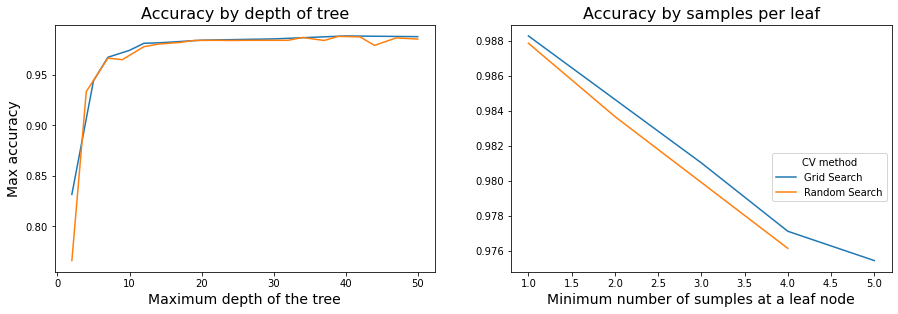

In [38]:
# plot hyperparameter tuning process
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
# plot hyperparameter tuning process of tree maximum depth
grid_search_results.groupby(['param_max_depth']).max()["mean_test_score"].plot(label='Grid Search')
random_search_results.groupby(['param_max_depth']).max()["mean_test_score"].plot(label='Random Search')
#plt.legend(title='CV method')

plt.ylabel('Max accuracy', fontsize=14)
plt.xlabel('Maximum depth of the tree', fontsize=14)
plt.title('Accuracy by depth of tree', fontsize=16)

plt.subplot(2,2,2)
# plot hyperparameter tuning process of leaf minimum sample
grid_search_results.groupby(['param_min_samples_leaf']).max()["mean_test_score"].plot(label='Grid Search', ax=plt.gca())
random_search_results.groupby(['param_min_samples_leaf']).max()["mean_test_score"].plot(label='Random Search', ax=plt.gca())
plt.legend(title='CV method', bbox_to_anchor=(1, 0.5))

#plt.ylabel('Max accuracy', fontsize=14)
plt.xlabel('Minimum number of sumples at a leaf node', fontsize=14)
plt.title('Accuracy by samples per leaf', fontsize=16)

plt.show()

In [39]:
log_models.loc[len(log_models)] = ['Random Forest',max(accuracy_score(y_test, y_pred_test_rs),accuracy_score(y_test, y_pred_test_gs)),
                                  max(balanced_accuracy_score(y_test, y_pred_test_rs),balanced_accuracy_score(y_test, y_pred_test_gs))]

## AdaBoost

In [40]:
# Predict labels ruuning the model one time 

# call the model
dtc = DecisionTreeClassifier(max_depth=8)
abt = AdaBoostClassifier(dtc, n_estimators=300, learning_rate=1)
#abt = AdaBoostClassifier(n_estimators=300, learning_rate=1)

# train the model for one time
abt.fit(x_vec_train, y_train)

# prediction accuracy of the train data
y_pred_train_ab = abt.predict(x_vec_train)
print('Accuracy of train data: ',accuracy_score(y_train, y_pred_train_ab))

# prediction accuracy of the test data
y_pred_test_ab = abt.predict(x_vec_test)
print('Accuracy of test data: ',accuracy_score(y_test, y_pred_test_ab))

Accuracy of train data:  0.9921864099344216
Accuracy of test data:  0.9355670103092784


#### Using cross validation

In [41]:
# Predict labels ruuning the model using cross validation

# call the model
dtc = DecisionTreeClassifier(max_depth=8)
abt = AdaBoostClassifier(dtc, n_estimators=300, learning_rate=1)

cv_scores = cross_val_score(abt, x_vec, y, cv=5)
print('Mean accuracy: ', round(cv_scores.mean()*100, 3), '% std: ', round(math.sqrt(cv_scores.var())*100, 3),'%')
print('The accuracy for cross validation is: ', round(cv_scores.mean(), 3), ' compared to single time training: ', round(accuracy_score(y_test, y_pred_test_ab), 3))

Mean accuracy:  96.979 % std:  1.863 %
The accuracy for cross validation is:  0.97  compared to single time training:  0.936


Using grid search method to optimize alpha parameter

In [42]:
# Create the random grid
param_grid = {'base_estimator__max_depth':[i for i in range(2,21,2)],
              'base_estimator__min_samples_leaf':[1,5,10],
              "base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2],
              'learning_rate':[0.01,0.1]
             }

dtc = DecisionTreeClassifier()
abt = AdaBoostClassifier(dtc, n_estimators=300, learning_rate=1)
grid_search = GridSearchCV(estimator = abt, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 0)
grid_search.fit(x_vec_train, y_train)

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                          learning_rate=1, n_estimators=300),
             n_jobs=-1,
             param_grid={'base_estimator__criterion': ['gini', 'entropy'],
                         'base_estimator__max_depth': [2, 4, 6, 8, 10, 12, 14,
                                                       16, 18, 20],
                         'base_estimator__min_samples_leaf': [1, 5, 10],
                         'base_estimator__splitter': ['best', 'random'],
                         'learning_rate': [0.01, 0.1], 'n_estimators': [1, 2]})

In [43]:
# plot in table the result of random search
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__criterion,param_base_estimator__max_depth,param_base_estimator__min_samples_leaf,param_base_estimator__splitter,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.156948,0.007490,0.003324,0.000232,gini,2,1,best,0.01,1,"{'base_estimator__criterion': 'gini', 'base_es...",0.279196,0.280033,0.279615,0.279615,0.000342,457
1,0.276223,0.008001,0.005184,0.000301,gini,2,1,best,0.01,2,"{'base_estimator__criterion': 'gini', 'base_es...",0.519464,0.520301,0.519046,0.519604,0.000522,433
2,0.142559,0.009232,0.004100,0.001316,gini,2,1,best,0.1,1,"{'base_estimator__criterion': 'gini', 'base_es...",0.279196,0.280033,0.279615,0.279615,0.000342,457
3,0.273699,0.003138,0.004716,0.000184,gini,2,1,best,0.1,2,"{'base_estimator__criterion': 'gini', 'base_es...",0.399330,0.400167,0.399330,0.399609,0.000395,442
4,0.013987,0.000836,0.002443,0.000250,gini,2,1,random,0.01,1,"{'base_estimator__criterion': 'gini', 'base_es...",0.279196,0.280033,0.279615,0.279615,0.000342,457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.293959,0.069197,0.003515,0.000792,entropy,20,10,best,0.1,2,"{'base_estimator__criterion': 'entropy', 'base...",0.983257,0.976141,0.978652,0.979350,0.002947,162
476,0.022303,0.003010,0.002580,0.000262,entropy,20,10,random,0.01,1,"{'base_estimator__criterion': 'entropy', 'base...",0.979908,0.977396,0.976141,0.977815,0.001566,175
477,0.038192,0.004577,0.004879,0.000388,entropy,20,10,random,0.01,2,"{'base_estimator__criterion': 'entropy', 'base...",0.983257,0.975722,0.976141,0.978373,0.003457,172
478,0.019817,0.002261,0.003497,0.000979,entropy,20,10,random,0.1,1,"{'base_estimator__criterion': 'entropy', 'base...",0.979489,0.975722,0.975722,0.976978,0.001776,181


In [44]:
# prediction accuracy of the train data
y_pred_train = grid_search.predict(x_vec_train)
print('Accuracy of best estimators with the train data: ',accuracy_score(y_train,y_pred_train))

# prediction accuracy of the test data
y_pred_test = grid_search.predict(x_vec_test)
print('Accuracy of best estimator with the test data: ',accuracy_score(y_test, y_pred_test))
best_grid_ab = grid_search.best_params_
print('The chosen hyperparameters are: ', best_grid_ab)

Accuracy of best estimators with the train data:  0.9861866889912098
Accuracy of best estimator with the test data:  0.961340206185567
The chosen hyperparameters are:  {'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 20, 'base_estimator__min_samples_leaf': 1, 'base_estimator__splitter': 'random', 'learning_rate': 0.01, 'n_estimators': 1}


In [45]:
log_models.loc[len(log_models)] = ['AdaBoost',accuracy_score(y_test, y_pred_test),balanced_accuracy_score(y_test, y_pred_test)]

### CatBoost

In [46]:
# Predict labels ruuning the model one time 

# call the model
cbt = CatBoostClassifier(
    iterations=10, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
    verbose=False
)

# train the model for one time
cbt.fit(x_vec_train, y_train)

# prediction accuracy of the train data
y_pred_train_cb = cbt.predict(x_vec_train)
print('Accuracy of train data: ',accuracy_score(y_train, y_pred_train_cb))

# prediction accuracy of the test data
y_pred_test_cb = cbt.predict(x_vec_test)
print('Accuracy of test data: ',accuracy_score(y_test, y_pred_test_cb))

Accuracy of train data:  0.9173991907353146
Accuracy of test data:  0.9768041237113402


#### Using cross validation

In [47]:
# Predict labels ruuning the model using cross validation

# call the model
cbt = CatBoostClassifier(
    iterations=10, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
    verbose=False
)

cv_scores = cross_val_score(cbt, x_vec, y, cv=5)
print('Mean accuracy: ', round(cv_scores.mean()*100, 3), '% std: ', round(math.sqrt(cv_scores.var())*100, 3),'%')
print('The accuracy for cross validation is: ', round(cv_scores.mean(), 3), ' compared to single time training: ', round(accuracy_score(y_test, y_pred_test_cb), 3))

Mean accuracy:  92.285 % std:  0.311 %
The accuracy for cross validation is:  0.923  compared to single time training:  0.977


Using grid search method to optimize alpha parameter

In [48]:
# Create the random grid
param_grid = {'learning_rate': [0.03, 0.1],
              'depth': [4, 6, 10],
              'l2_leaf_reg': np.logspace(-20, -19, 3),
              'loss_function':['MultiClass']}

cbt = CatBoostClassifier(
    iterations=10, 
    verbose=False
)
grid_search = GridSearchCV(estimator = cbt, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 0)
grid_search.fit(x_vec_train, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fd9929c7520>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 10],
                         'l2_leaf_reg': array([1.00000000e-20, 3.16227766e-20, 1.00000000e-19]),
                         'learning_rate': [0.03, 0.1],
                         'loss_function': ['MultiClass']})

In [49]:
# plot in table the result of random search
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_l2_leaf_reg,param_learning_rate,param_loss_function,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.420058,0.007711,0.008838,0.000853,4,0.0,0.03,MultiClass,"{'depth': 4, 'l2_leaf_reg': 1e-20, 'learning_r...",0.921725,0.878192,0.877773,0.892563,0.020621,16
1,0.408513,0.023729,0.008710,0.001741,4,0.0,0.1,MultiClass,"{'depth': 4, 'l2_leaf_reg': 1e-20, 'learning_r...",0.928422,0.878192,0.920887,0.909167,0.022118,13
2,0.393447,0.033282,0.007686,0.001035,4,0.0,0.03,MultiClass,"{'depth': 4, 'l2_leaf_reg': 3.162277660168379e...",0.921725,0.878192,0.877773,0.892563,0.020621,16
3,0.341956,0.025910,0.007155,0.000214,4,0.0,0.1,MultiClass,"{'depth': 4, 'l2_leaf_reg': 3.162277660168379e...",0.928422,0.878192,0.920887,0.909167,0.022118,13
4,0.345064,0.019060,0.007507,0.000275,4,0.0,0.03,MultiClass,"{'depth': 4, 'l2_leaf_reg': 1e-19, 'learning_r...",0.921725,0.878192,0.877773,0.892563,0.020621,16
5,0.406101,0.077752,0.014806,0.004876,4,0.0,0.1,MultiClass,"{'depth': 4, 'l2_leaf_reg': 1e-19, 'learning_r...",0.928422,0.878192,0.920887,0.909167,0.022118,13
6,0.964551,0.063244,0.009867,0.003266,6,0.0,0.03,MultiClass,"{'depth': 6, 'l2_leaf_reg': 1e-20, 'learning_r...",0.920050,0.920469,0.921725,0.920748,0.000711,10
7,1.038477,0.056496,0.009148,0.003841,6,0.0,0.1,MultiClass,"{'depth': 6, 'l2_leaf_reg': 1e-20, 'learning_r...",0.922143,0.920050,0.922562,0.921585,0.001099,7
8,0.996378,0.015069,0.009456,0.002390,6,0.0,0.03,MultiClass,"{'depth': 6, 'l2_leaf_reg': 3.162277660168379e...",0.920050,0.920469,0.921725,0.920748,0.000711,10
9,0.981381,0.032405,0.006918,0.000485,6,0.0,0.1,MultiClass,"{'depth': 6, 'l2_leaf_reg': 3.162277660168379e...",0.922143,0.920050,0.922562,0.921585,0.001099,7


In [50]:
# prediction accuracy of the train data
y_pred_train = grid_search.predict(x_vec_train)
print('Accuracy of best estimators with the train data: ',accuracy_score(y_train,y_pred_train))

# prediction accuracy of the test data
y_pred_test = grid_search.predict(x_vec_test)
print('Accuracy of best estimator with the test data: ',accuracy_score(y_test, y_pred_test))
best_grid_cb = grid_search.best_params_
print('The chosen hyperparameters are: ', best_grid_cb)

Accuracy of best estimators with the train data:  0.9540951583647272
Accuracy of best estimator with the test data:  0.8969072164948454
The chosen hyperparameters are:  {'depth': 10, 'l2_leaf_reg': 1e-20, 'learning_rate': 0.1, 'loss_function': 'MultiClass'}


In [51]:
log_models.loc[len(log_models)] = ['CatBoost',accuracy_score(y_test, y_pred_test),balanced_accuracy_score(y_test, y_pred_test)]

### Box plot of classification accuracy by each model

In [52]:
log_models = log_models.set_index('Classifier')
log_models

,Accuracy,Balanced Accuracy
Classifier,,
Naive Bayes,0.881443,0.802033
Logistic Regression,0.907216,0.817566
Random Forest,0.935567,0.824327
AdaBoost,0.961340,0.912483
CatBoost,0.896907,0.903766


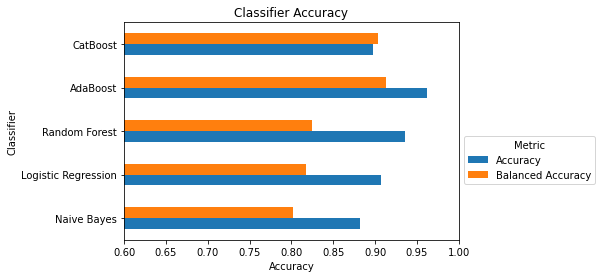

In [53]:
log_models.plot.barh()
plt.title('Classifier Accuracy')
plt.legend(title='Metric', bbox_to_anchor=(1, 0.5))
plt.xlabel('Accuracy')
plt.xlim((0.6,1))
plt.show()

The model with the best accuracy:

In [56]:
log_models.index[log_models['Balanced Accuracy']==max(log_models['Balanced Accuracy'])]

Index(['AdaBoost'], dtype='object', name='Classifier')